In [1]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k

stop = 1400



2024-02-12 11:01:31.116530: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:01:31.969182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 11:01:31.969295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 11:01:31.974040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 11:01:32.456849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 11:01:32.461417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data Loading and Preparation

**Let's start by loading our old dataset**

We will focus on the FD004 data:

### Data loading

In [2]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection
- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [3]:
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [4]:
#print the data with 'machine' = 1
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,train_FD001,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,...,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
188,train_FD001,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,train_FD001,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,train_FD001,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1


We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

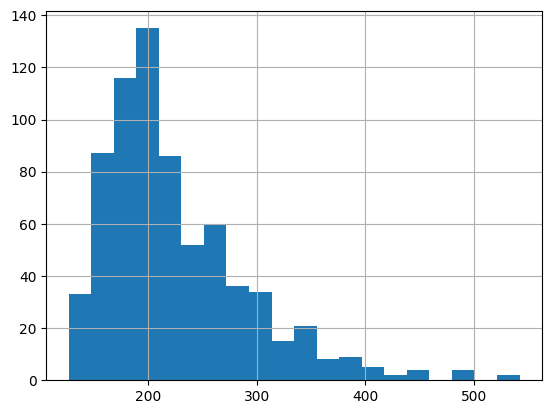

In [5]:
#define a histogram with value of rul for each machine where cycle=1 and src='FD001'
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)


In [4]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [5]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

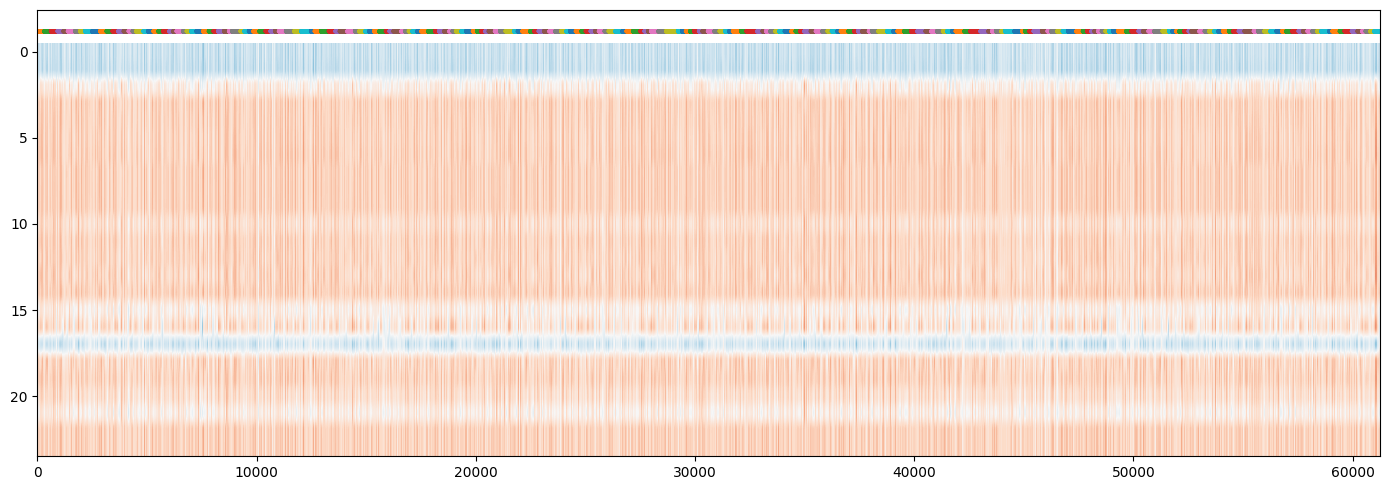

In [8]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

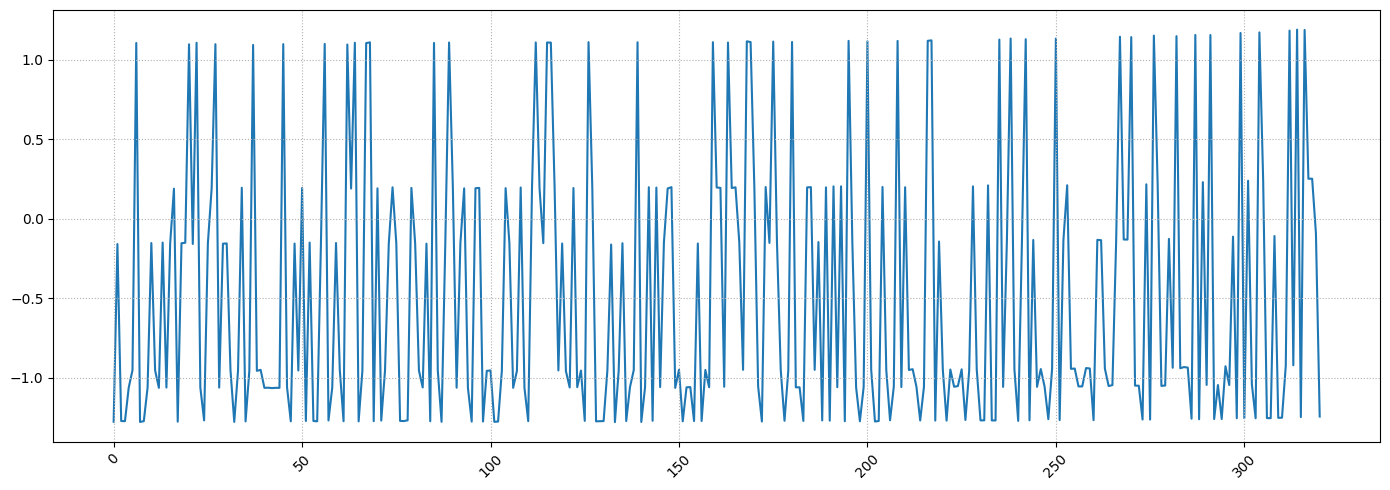

In [9]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [7]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [8]:
dt.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,1.500057,1.168664,0.345954,-1.342550,-1.122474,-1.045952,-1.086033,...,0.344929,-0.175148,0.370889,-1.037783,-0.989600,-0.433322,0.345954,-1.310594,-1.311278,320
1,train_FD004,461,2,0.168806,0.788709,0.345954,0.175840,0.205021,0.089480,-0.172094,...,0.342590,-0.531124,0.181688,-1.037783,0.009709,0.352571,0.345954,-0.134518,-0.129792,319
2,train_FD004,461,3,1.499991,1.171110,0.345954,-1.342550,-1.139659,-1.048575,-1.055806,...,0.344749,-0.276979,0.460301,-1.037783,-1.021836,-0.433322,0.345954,-1.322569,-1.303537,318
3,train_FD004,461,4,1.499761,1.168664,0.345954,-1.342550,-1.145544,-1.064484,-1.048616,...,0.345198,-0.160016,0.375413,-1.037783,-1.054071,-0.433322,0.345954,-1.317437,-1.304065,317
4,train_FD004,461,5,0.471584,0.572641,-2.890543,-0.765963,-1.442165,-1.792301,-1.668131,...,-2.892626,-2.767824,2.370806,-1.037783,-1.795494,-2.517341,-2.890543,-1.018927,-0.982214,316


## Project

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

#### TODO: spostare queste funzioni in util (nb decidere se fare anche funzione per train)

### Task 1: train the model with only supervised data. We will experiment with different ratios of supervised data. 
In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better. 
- Moreover, we expect that they learn the decreasing tred and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances won't be as significant as those in the models with both supervised and unsupervised data. 

#### 1.1 100% of supervised data used for training

In [12]:
trs, ts = cst.split_machines(dt, 0.75, 0)

Num. machines: 186 (supervised), 63 (test)


In [13]:
trs_s, ts_s, trmaxrul = cst.standardize(trs, ts, dt_in)

We train the model with different seeds

In [88]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/5
760/760 [==============================] - 3s 3ms/step - loss: 0.0014 - mse: 0.0278 - cst: 0.0014
Epoch 2/5
760/760 [==============================] - 2s 3ms/step - loss: 5.7414e-04 - mse: 0.0296 - cst: 5.7414e-04
Epoch 3/5
760/760 [==============================] - 2s 3ms/step - loss: 5.6586e-04 - mse: 0.0330 - cst: 5.6586e-04
Epoch 4/5
760/760 [==============================] - 2s 2ms/step - loss: 4.8726e-04 - mse: 0.0372 - cst: 4.8726e-04
Epoch 5/5
496/496 [==============================] - 0s 464us/step
Epoch 1/5
760/760 [==============================] - 2s 2ms/step - loss: 0.0021 - mse: 0.2438 - cst: 0.0021
Epoch 2/5
760/760 [==============================] - 2s 2ms/step - loss: 5.5204e-04 - mse: 0.1856 - cst: 5.5204e-04
Epoch 3/5
760/760 [==============================] - 2s 2ms/step - loss: 5.3854e-04 - mse: 0.1515 - cst: 5.3854e-04
Epoch 4/5
760/760 [==============================] - 2s 2ms/step - loss: 4.9818e-04 - mse: 0.1265 - cst: 4.9818e-04
Epoch 5/5
496/496 [==

Evaluation on the test set

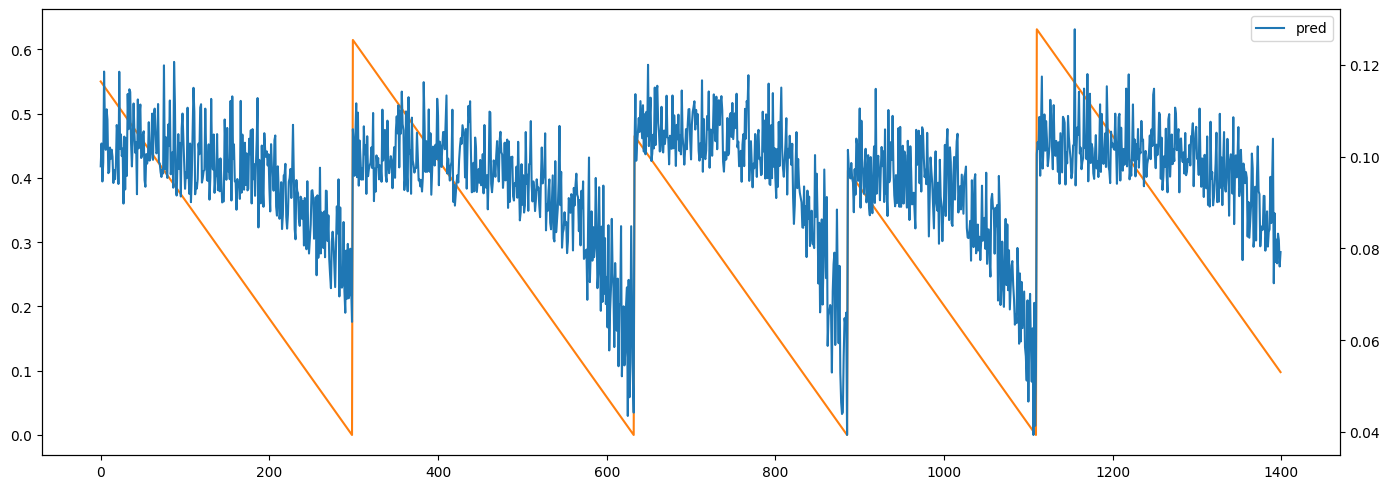

In [90]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0792
Deviazione standard della MSE: 0.0100


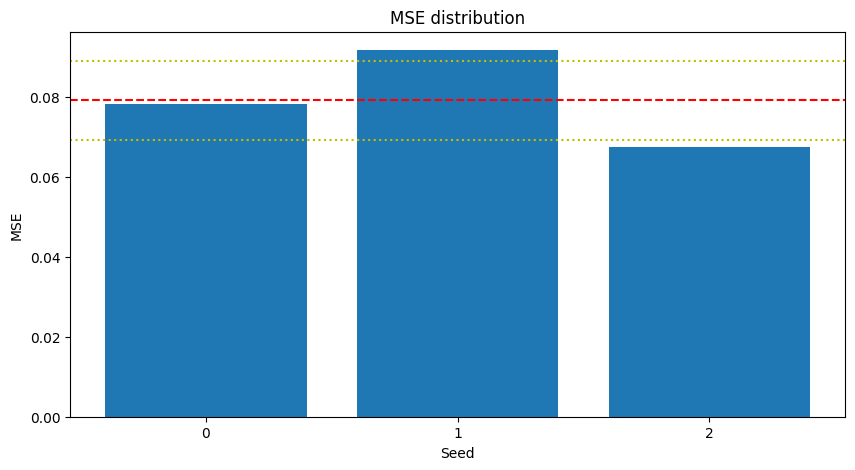

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 1.2 75% of supervised data used for training

In [16]:
trs_2 = cst.split_data(ts, trs=trs, trs_ratio=0.75)

Num. samples: 34038 (supervised), 15864 (test)


In [17]:
trs_s, ts_s, trmaxrul = cst.standardize(trs_2, ts, dt_in)

In [48]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1138/1138 [==============================] - 3s 3ms/step - loss: 0.0043 - mse: 0.0345 - cst: 0.0043
Epoch 2/5
1138/1138 [==============================] - 3s 3ms/step - loss: 5.8153e-04 - mse: 0.0323 - cst: 5.8153e-04
Epoch 3/5
1138/1138 [==============================] - 3s 3ms/step - loss: 5.3817e-04 - mse: 0.0320 - cst: 5.3817e-04
Epoch 4/5
1138/1138 [==============================] - 3s 3ms/step - loss: 5.6603e-04 - mse: 0.0329 - cst: 5.6603e-04
Epoch 5/5
496/496 [==============================] - 0s 414us/step
Epoch 1/5
1138/1138 [==============================] - 3s 3ms/step - loss: 0.0081 - mse: 0.3169 - cst: 0.0081
Epoch 2/5
1138/1138 [==============================] - 3s 3ms/step - loss: 6.0937e-04 - mse: 0.2467 - cst: 6.0937e-04
Epoch 3/5
1138/1138 [==============================] - 3s 3ms/step - loss: 5.8363e-04 - mse: 0.2128 - cst: 5.8363e-04
Epoch 4/5
1138/1138 [==============================] - 3s 3ms/step - loss: 5.5398e-04 - mse: 0.1894 - cst: 5.5398e-04
Epoch

Evaluation on the test set 

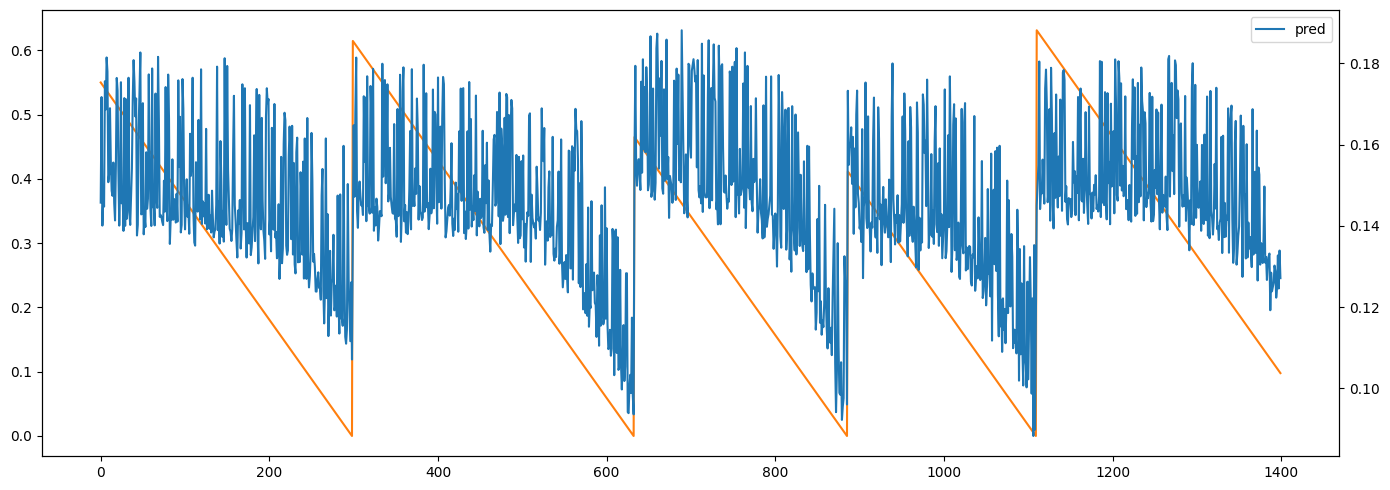

In [49]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [50]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0837
Deviazione standard della MSE: 0.0553


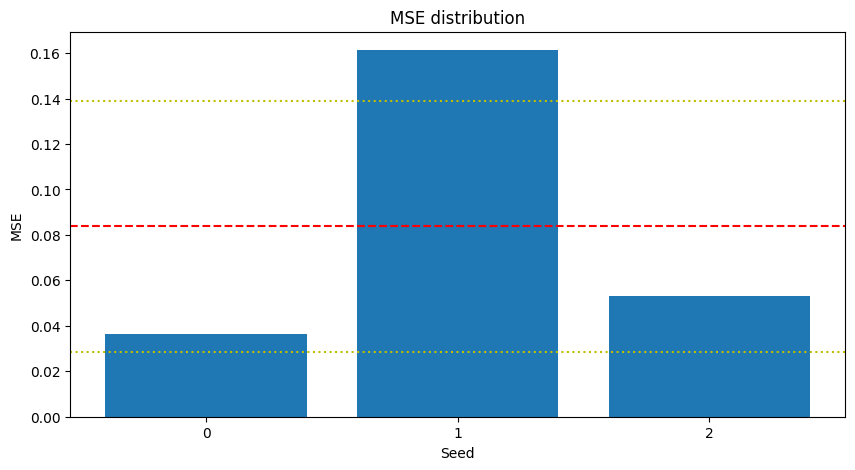

In [51]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 1.3 50% of supervised data used for training

In [52]:
trs_3 = cst.split_data(ts, trs=trs, trs_ratio=0.50)

Num. samples: 22692 (supervised), 15864 (test)


In [53]:
trs_s, ts_s, trmaxrul = cst.standardize(trs_3, ts, dt_in)

In [54]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/5
760/760 [==============================] - 2s 2ms/step - loss: 0.0025 - mse: 0.1578 - cst: 0.0025
Epoch 2/5
760/760 [==============================] - 2s 2ms/step - loss: 6.0262e-04 - mse: 0.1069 - cst: 6.0262e-04
Epoch 3/5
760/760 [==============================] - 2s 2ms/step - loss: 6.1840e-04 - mse: 0.0934 - cst: 6.1840e-04
Epoch 4/5
760/760 [==============================] - 2s 2ms/step - loss: 5.2637e-04 - mse: 0.0877 - cst: 5.2637e-04
Epoch 5/5
496/496 [==============================] - 0s 780us/step
Epoch 1/5
760/760 [==============================] - 2s 2ms/step - loss: 0.0014 - mse: 0.3468 - cst: 0.0014
Epoch 2/5
760/760 [==============================] - 2s 2ms/step - loss: 5.2262e-04 - mse: 0.2731 - cst: 5.2262e-04
Epoch 3/5
760/760 [==============================] - 2s 2ms/step - loss: 5.2074e-04 - mse: 0.2328 - cst: 5.2074e-04
Epoch 4/5
760/760 [==============================] - 2s 2ms/step - loss: 4.7612e-04 - mse: 0.2003 - cst: 4.7612e-04
Epoch 5/5
496/496 [==

Evaluation on the test set

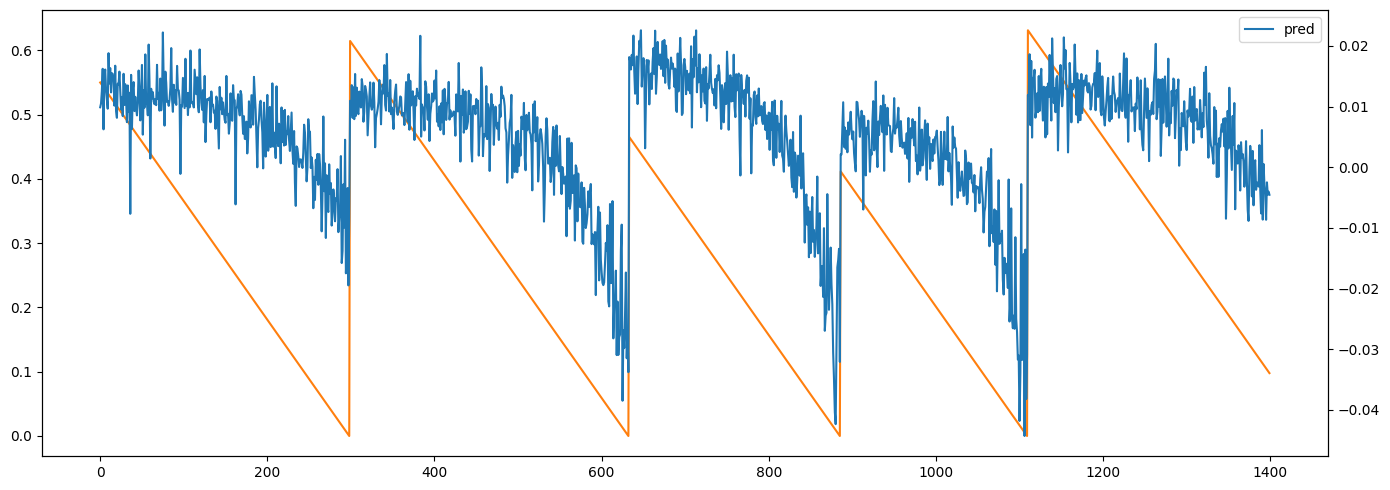

In [58]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [59]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.1115
Deviazione standard della MSE: 0.0501


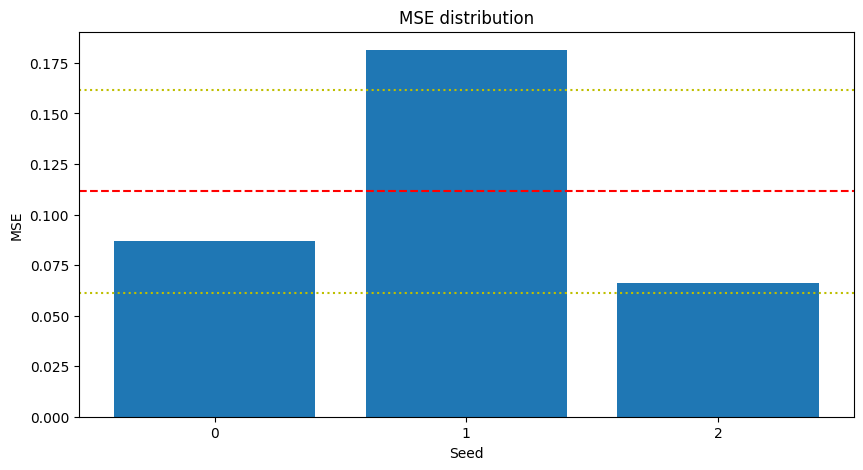

In [60]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

**results**

### Task 2: train the model with only unsupervised data. We will experiment with different ratios of supervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the rul. However, we will see if it is possible for the regressor to learn the constraint which imposes that the rul for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial rul as accurately as the supervised models.

In [18]:
tru, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 186 (unsupervised), 63 (test)


In [31]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 45385 (unsupervised), 15864 (test)


#### 100% of unsupervised data

In [19]:
tru_s, ts_s, trmaxrul = cst.standardize(tru, ts, dt_in)

Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [20]:
tru_st = cst.remove_rul(tru_s)

In [66]:
pred = []
for i in range(3):
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0043 - mse: 0.0000e+00 - cst: 0.0043
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 5.5235e-04 - mse: 0.0000e+00 - cst: 5.5235e-04
Epoch 3/5
1339/1339 [==============================] - 4s 3ms/step - loss: 5.7777e-04 - mse: 0.0000e+00 - cst: 5.7777e-04
Epoch 4/5
1339/1339 [==============================] - 4s 3ms/step - loss: 5.3978e-04 - mse: 0.0000e+00 - cst: 5.3978e-04
Epoch 5/5
496/496 [==============================] - 0s 376us/step
Epoch 1/5
1339/1339 [==============================] - 5s 3ms/step - loss: 0.0024 - mse: 0.0000e+00 - cst: 0.0024
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 5.2865e-04 - mse: 0.0000e+00 - cst: 5.2865e-04
Epoch 3/5
1339/1339 [==============================] - 4s 3ms/step - loss: 5.1939e-04 - mse: 0.0000e+00 - cst: 5.1939e-04
Epoch 4/5
1339/1339 [==============================] - 4s 3ms/step - loss: 4.9466e-04 - mse: 0.

Evaluation on the test set

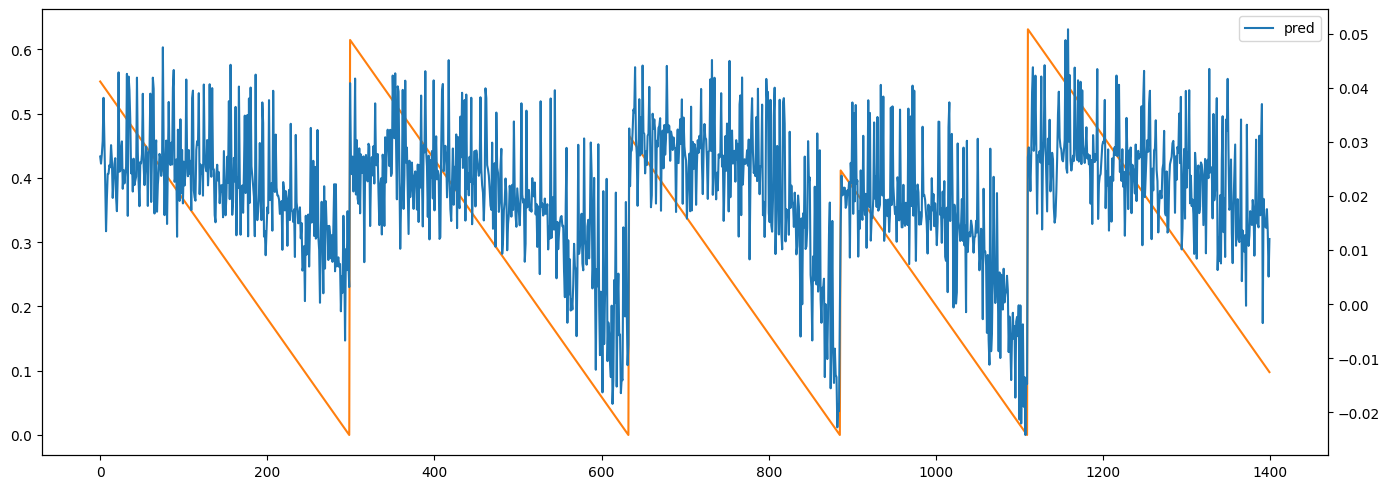

In [67]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [68]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0762
Deviazione standard della MSE: 0.0027


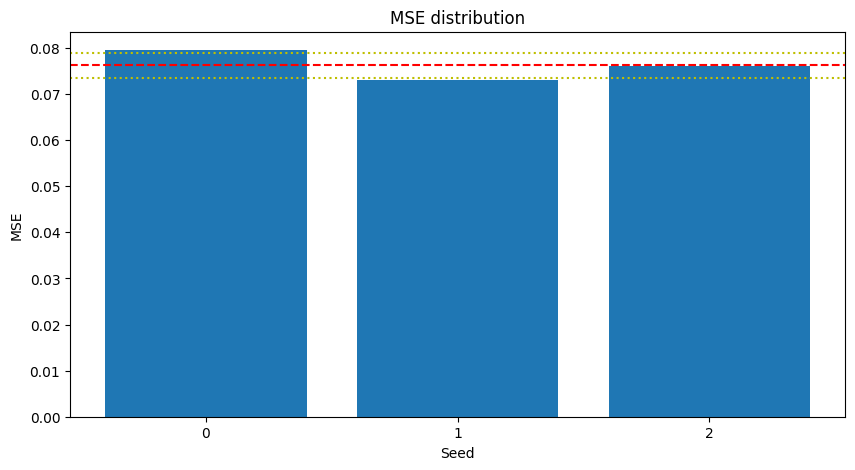

In [69]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 75% of unsupervised data

In [70]:
tru_2 = cst.split_data(ts, tru=tru, tru_ratio=0.75)

Num. samples: 34038 (unsupervised), 15864 (test)


In [71]:
tru_s, ts_s, trmaxrul = cst.standardize(tru_2, ts, dt_in)

In [72]:
tru_st = cst.remove_rul(tru_s)

In [77]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1001/1001 [==============================] - 3s 2ms/step - loss: 0.0028 - mse: 0.0000e+00 - cst: 0.0028
Epoch 2/5
1001/1001 [==============================] - 3s 3ms/step - loss: 5.1408e-04 - mse: 0.0000e+00 - cst: 5.1408e-04
Epoch 3/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.8653e-04 - mse: 0.0000e+00 - cst: 4.8653e-04
Epoch 4/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.7500e-04 - mse: 0.0000e+00 - cst: 4.7500e-04
Epoch 5/5
496/496 [==============================] - 0s 478us/step
Epoch 1/5
1001/1001 [==============================] - 3s 3ms/step - loss: 9.1514e-04 - mse: 0.0000e+00 - cst: 9.1514e-04
Epoch 2/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.7960e-04 - mse: 0.0000e+00 - cst: 4.7960e-04
Epoch 3/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.5369e-04 - mse: 0.0000e+00 - cst: 4.5369e-04
Epoch 4/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.2330e-04 -

Evaluation on the test set

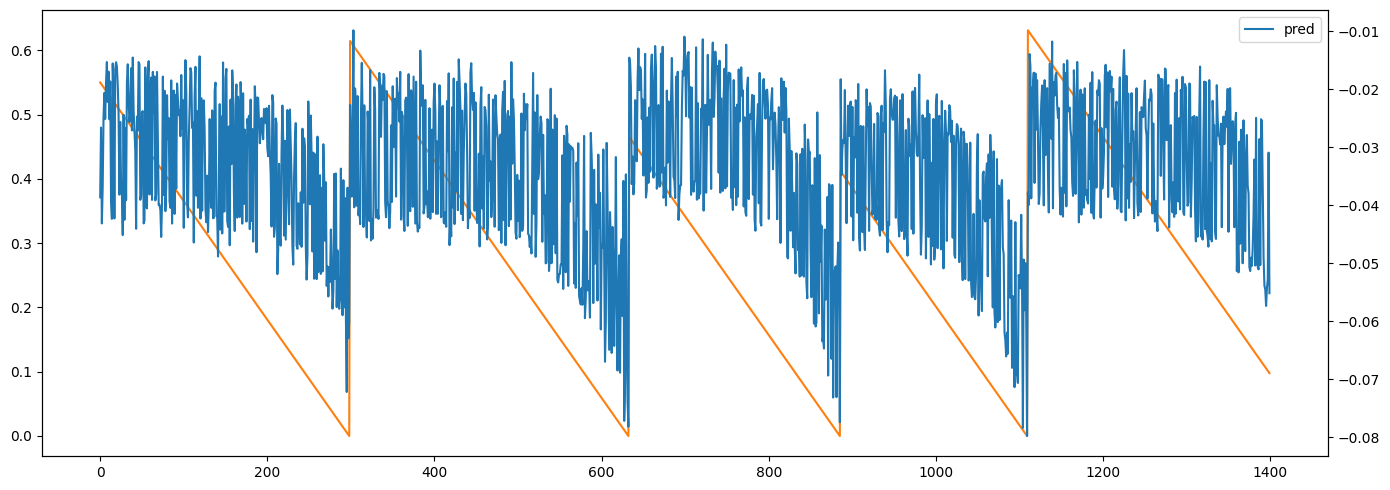

In [78]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [79]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0968
Deviazione standard della MSE: 0.0145


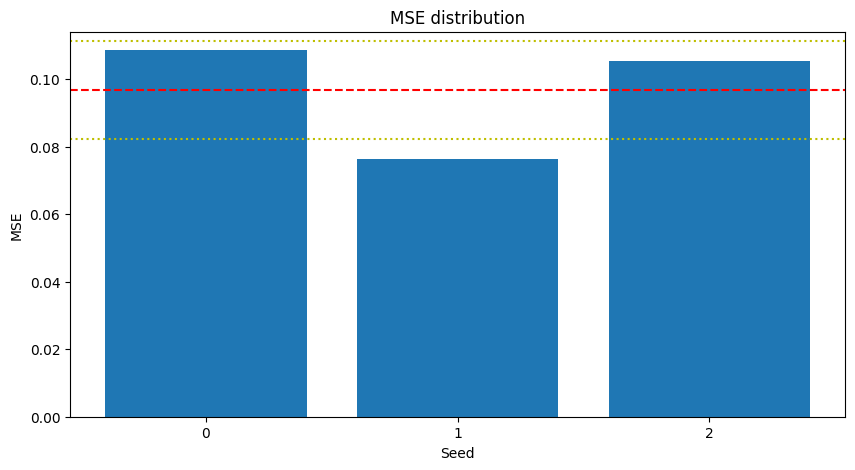

In [80]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 50% of unsupervised

In [81]:
tru_3 = cst.split_data(ts, tru=tru, tru_ratio=0.50)

Num. samples: 22692 (unsupervised), 15864 (test)


In [82]:
tru_s, ts_s, trmaxrul = cst.standardize(tru_3, ts, dt_in)

In [83]:
tru_st = cst.remove_rul(tru_s)

In [84]:
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
670/670 [==============================] - 2s 2ms/step - loss: 0.0069 - mse: 0.0000e+00 - cst: 0.0069
Epoch 2/5
670/670 [==============================] - 1s 2ms/step - loss: 5.0147e-04 - mse: 0.0000e+00 - cst: 5.0147e-04
Epoch 3/5
670/670 [==============================] - 1s 2ms/step - loss: 4.6723e-04 - mse: 0.0000e+00 - cst: 4.6723e-04
Epoch 4/5
670/670 [==============================] - 1s 2ms/step - loss: 4.5410e-04 - mse: 0.0000e+00 - cst: 4.5410e-04
Epoch 5/5
496/496 [==============================] - 0s 384us/step
Epoch 1/5
670/670 [==============================] - 2s 2ms/step - loss: 0.0040 - mse: 0.0000e+00 - cst: 0.0040
Epoch 2/5
670/670 [==============================] - 1s 2ms/step - loss: 4.7565e-04 - mse: 0.0000e+00 - cst: 4.7565e-04
Epoch 3/5
670/670 [==============================] - 1s 2ms/step - loss: 4.5469e-04 - mse: 0.0000e+00 - cst: 4.5469e-04
Epoch 4/5
670/670 [==============================] - 1s 2ms/step - loss: 4.6573e-04 - mse: 0.0000e+00 - cst: 

Evaluation on the test set

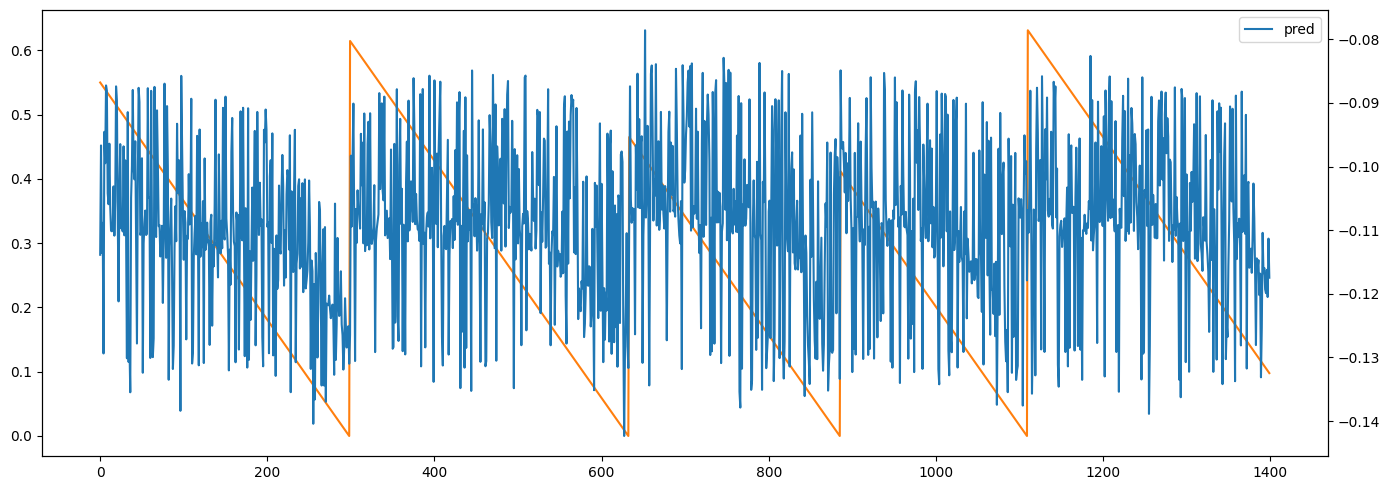

In [85]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [86]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.1123
Deviazione standard della MSE: 0.0416


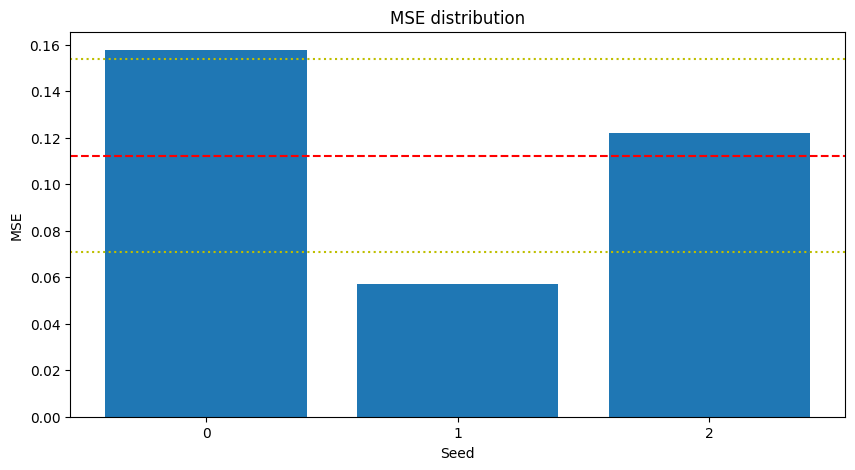

In [87]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

**results**
meglio del previsto

### Task 3: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of supervised models. Moreover, changing the ratio will greatly influence the performances of the models. *scrivere per le combinazioni*
- increasing the number of supervised samples, with fixed unsupervised samples, will lead to a more performing model
- increasing the number of unsupervised samples, with fixed supervised samples, will lead to a less performing model


#### FIXED NUMBER OF UNSUPERVISED - DECREASING NUMBER OF SUPERVISED 

In [9]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 124 (supervised), 62 (unsupervised), 63 (test)


##### 1. 100% unsupervised, 100% supervised

In [256]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 14813 (unsupervised), 15864 (test)


In [257]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [258]:
tru_st = cst.remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [259]:
trsu_s = pd.concat((trs_s, tru_st))

In [260]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 124.5045 - mse: 0.1617 - cst: 124.5045
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.7646 - mse: 0.7725 - cst: 121.7646
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.1747 - mse: 3.5487 - cst: 121.1747
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 120.2364 - mse: 6.8375 - cst: 120.2364
Epoch 5/5
1465/1465 [==============================] - 4s 3ms/step - loss: 119.5118 - mse: 10.1947 - cst: 119.5118


43/43 [==============================] - 0s 479us/step


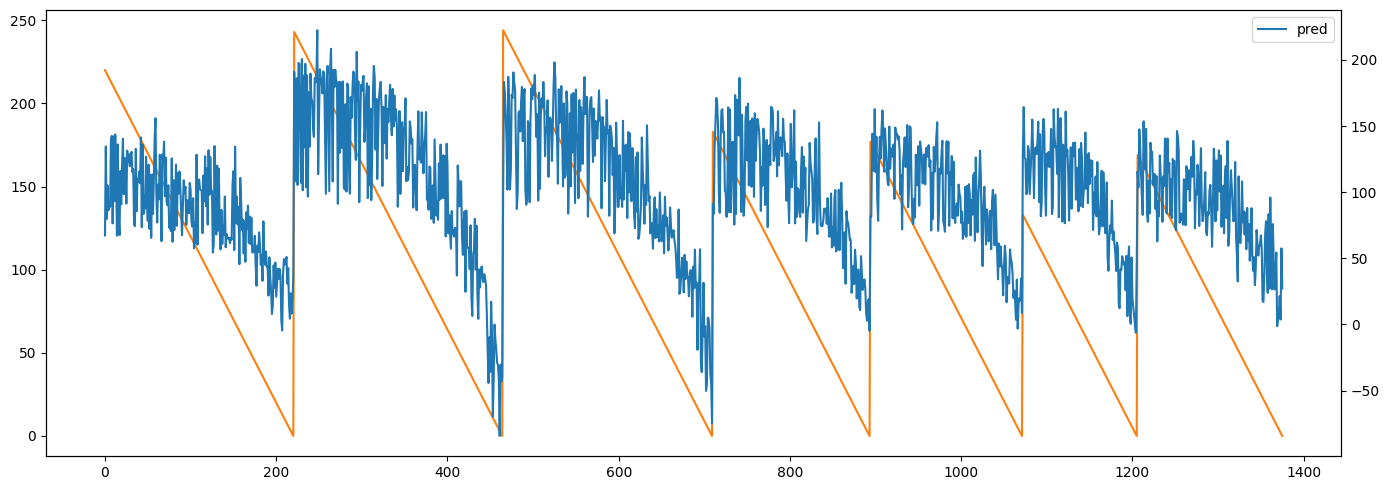

In [13]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 1. 100% unsupervised, 50% supervised

In [12]:
ratio_sup = 0.50 # 50 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 15286 (supervised), 14813 (unsupervised), 15864 (test)


In [13]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [14]:
tru_st = cst.remove_rul(tru_s)

In [15]:
trsu_s = pd.concat((trs_s, tru_st))

In [16]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
949/949 [==============================] - 20s 19ms/step - loss: 0.0017 - mse: 0.0421 - cst: 0.0017
Epoch 2/5
949/949 [==============================] - 18s 18ms/step - loss: 4.9643e-04 - mse: 0.0389 - cst: 4.9643e-04
Epoch 3/5
949/949 [==============================] - 18s 18ms/step - loss: 4.6950e-04 - mse: 0.0387 - cst: 4.6950e-04
Epoch 4/5
949/949 [==============================] - 16s 17ms/step - loss: 4.3068e-04 - mse: 0.0405 - cst: 4.3068e-04
Epoch 5/5
496/496 [==============================] - 2s 4ms/step
Epoch 1/5
949/949 [==============================] - 18s 17ms/step - loss: 8.2852e-04 - mse: 0.1029 - cst: 8.2852e-04
Epoch 2/5
949/949 [==============================] - 16s 17ms/step - loss: 4.7581e-04 - mse: 0.0838 - cst: 4.7581e-04
Epoch 3/5
949/949 [==============================] - 16s 17ms/step - loss: 4.7120e-04 - mse: 0.0773 - cst: 4.7120e-04
Epoch 4/5
949/949 [==============================] - 16s 17ms/step - loss: 4.2094e-04 - mse: 0.0708 - cst: 4.2094e-04

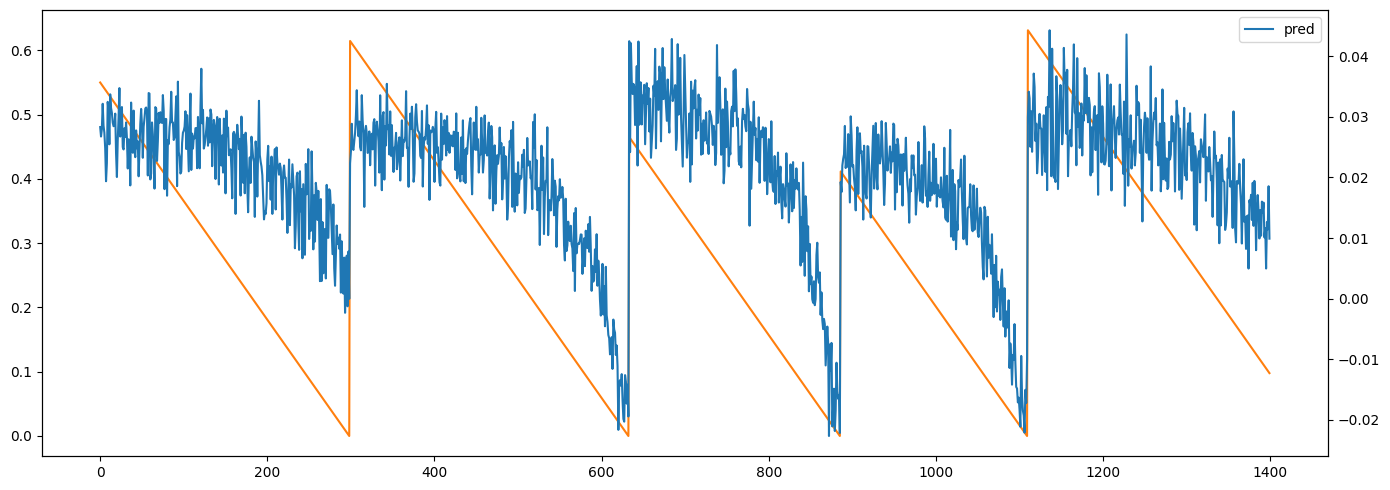

In [17]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [18]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0973
Deviazione standard della MSE: 0.0135


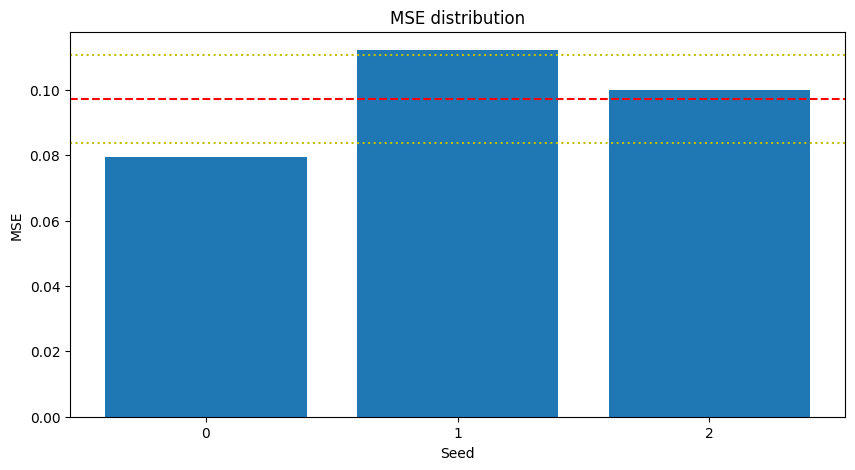

In [19]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 1. 100% unsupervised, 25% supervised

In [20]:
ratio_sup = 0.25 # 20 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 3821 (supervised), 14813 (unsupervised), 15864 (test)


In [21]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [22]:
tru_st = cst.remove_rul(tru_s)

In [23]:
trsu_s = pd.concat((trs_s, tru_st))

In [24]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
567/567 [==============================] - 7s 11ms/step - loss: 0.0046 - mse: 0.0573 - cst: 0.0046
Epoch 2/5
567/567 [==============================] - 6s 10ms/step - loss: 4.5388e-04 - mse: 0.0494 - cst: 4.5388e-04
Epoch 3/5
567/567 [==============================] - 5s 9ms/step - loss: 4.4685e-04 - mse: 0.0471 - cst: 4.4685e-04
Epoch 4/5
567/567 [==============================] - 5s 9ms/step - loss: 4.2384e-04 - mse: 0.0445 - cst: 4.2384e-04
Epoch 5/5
496/496 [==============================] - 1s 2ms/step
Epoch 1/5
567/567 [==============================] - 7s 10ms/step - loss: 0.0205 - mse: 0.0067 - cst: 0.0205
Epoch 2/5
567/567 [==============================] - 6s 11ms/step - loss: 4.6016e-04 - mse: 0.0062 - cst: 4.6016e-04
Epoch 3/5
567/567 [==============================] - 6s 10ms/step - loss: 4.4322e-04 - mse: 0.0059 - cst: 4.4322e-04
Epoch 4/5
567/567 [==============================] - 7s 12ms/step - loss: 4.3733e-04 - mse: 0.0056 - cst: 4.3733e-04
Epoch 5/5
496/496

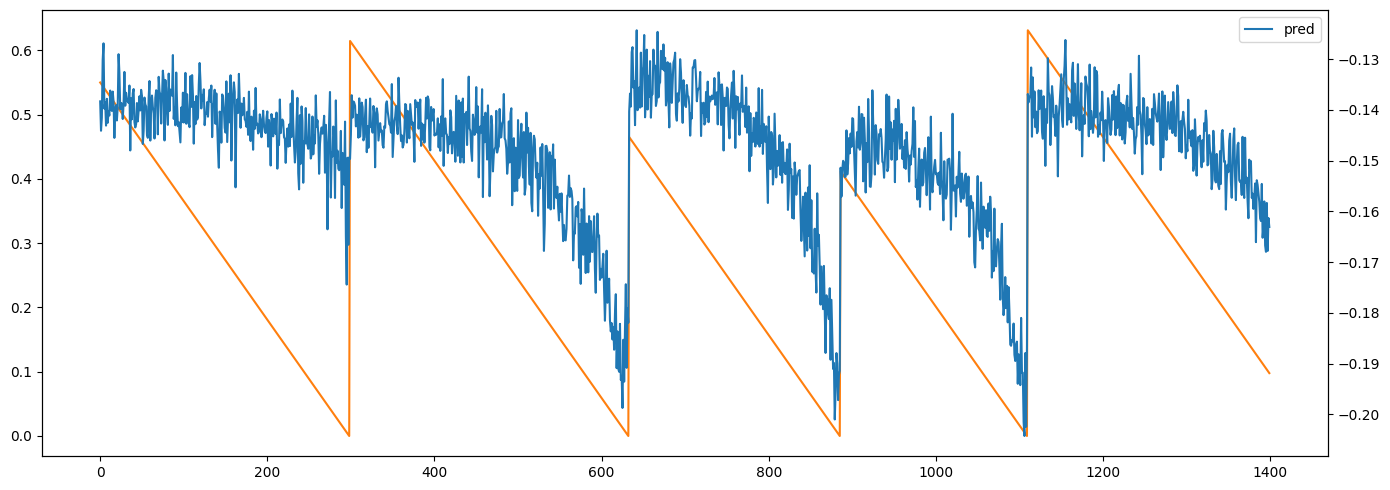

In [25]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [26]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0954
Deviazione standard della MSE: 0.0665


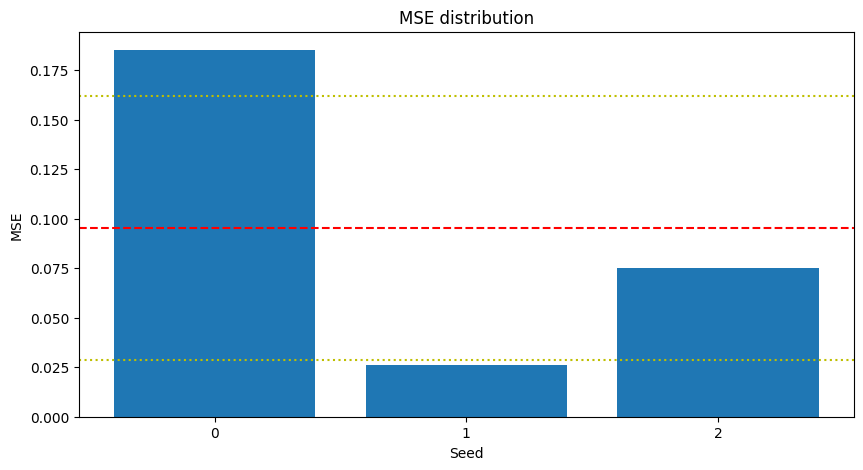

In [27]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### FIXED NUMBER OF SUPERVISED - DECREASING NUMBER OF UNSUPERVISED 

In [32]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 124 (supervised), 62 (unsupervised), 63 (test)


##### 1. 100% unsupervised, 100% supervised  -> UGUALE A PRIMA , TOGLIERE

In [ ]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 14813 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [ ]:
tru_st = cst.remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [ ]:
trsu_s = pd.concat((trs_s, tru_st))

In [ ]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 124.5045 - mse: 0.1617 - cst: 124.5045
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.7646 - mse: 0.7725 - cst: 121.7646
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.1747 - mse: 3.5487 - cst: 121.1747
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 120.2364 - mse: 6.8375 - cst: 120.2364
Epoch 5/5
1465/1465 [==============================] - 4s 3ms/step - loss: 119.5118 - mse: 10.1947 - cst: 119.5118


43/43 [==============================] - 0s 479us/step


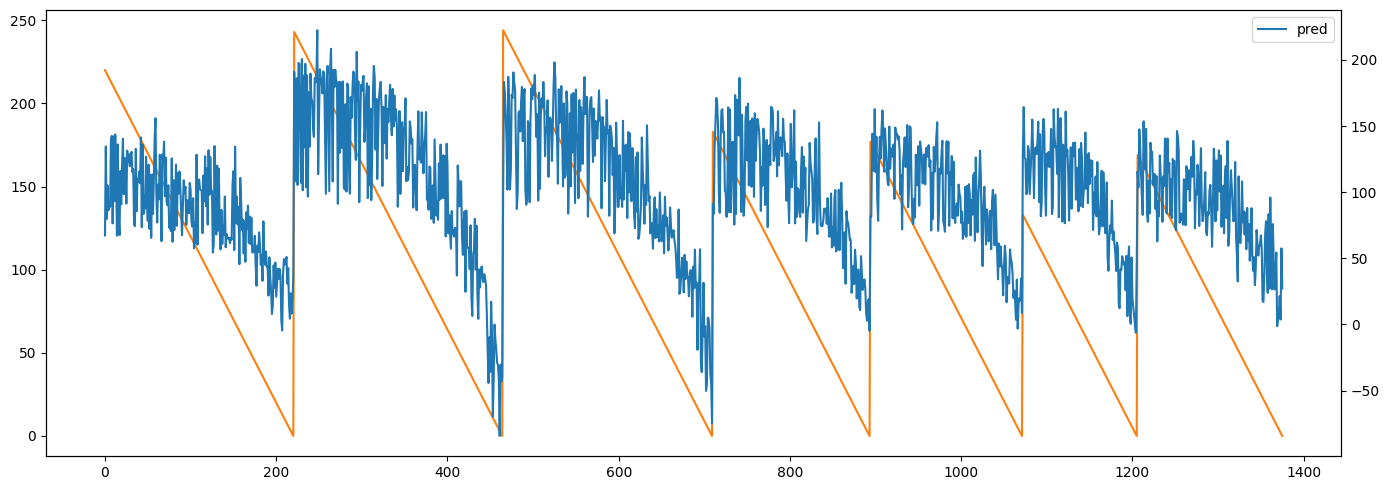

In [ ]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 1. 100% unsupervised, 50% supervised

In [33]:
ratio_unsup = 0.50 # 50% of unsupervised 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [34]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [35]:
tru_st = cst.remove_rul(tru_s)

In [36]:
trsu_s = pd.concat((trs_s, tru_st))

In [37]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1243/1243 [==============================] - 18s 14ms/step - loss: 0.0013 - mse: 0.0558 - cst: 0.0013
Epoch 2/5
1243/1243 [==============================] - 16s 13ms/step - loss: 5.3351e-04 - mse: 0.0538 - cst: 5.3351e-04
Epoch 3/5
1243/1243 [==============================] - 15s 12ms/step - loss: 5.0381e-04 - mse: 0.0548 - cst: 5.0381e-04
Epoch 4/5
1243/1243 [==============================] - 16s 13ms/step - loss: 4.8163e-04 - mse: 0.0579 - cst: 4.8163e-04
Epoch 5/5
496/496 [==============================] - 1s 2ms/step
Epoch 1/5
1243/1243 [==============================] - 14s 11ms/step - loss: 0.0022 - mse: 0.0247 - cst: 0.0022
Epoch 2/5
1243/1243 [==============================] - 13s 11ms/step - loss: 5.3235e-04 - mse: 0.0231 - cst: 5.3235e-04
Epoch 3/5
1243/1243 [==============================] - 13s 11ms/step - loss: 5.2384e-04 - mse: 0.0248 - cst: 5.2384e-04
Epoch 4/5
1243/1243 [==============================] - 13s 11ms/step - loss: 5.1111e-04 - mse: 0.0294 - cst: 5.

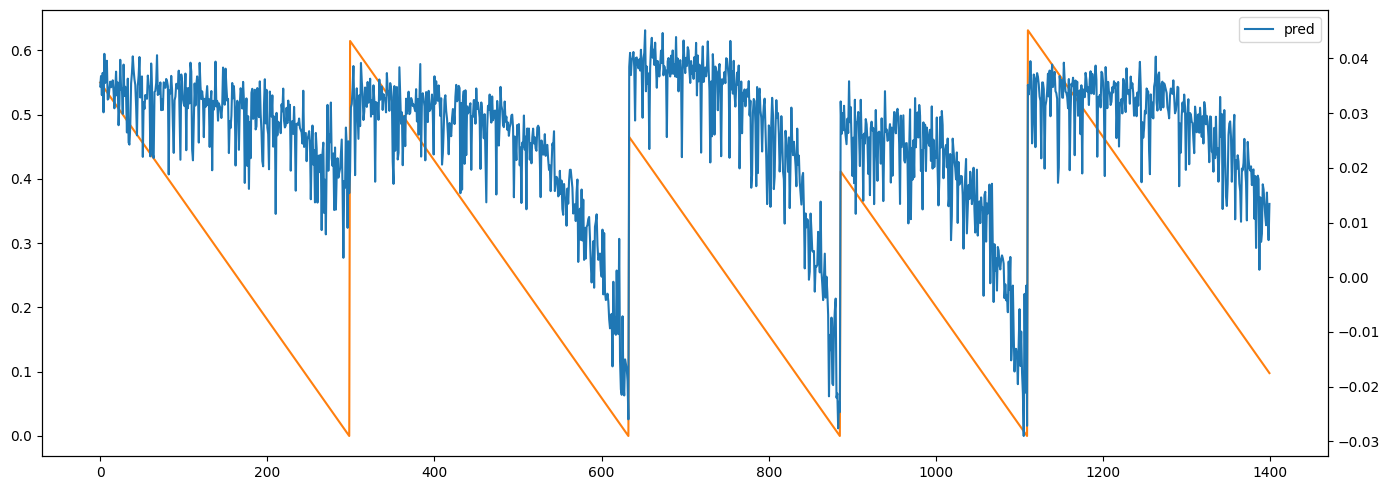

In [38]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [39]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0518
Deviazione standard della MSE: 0.0183


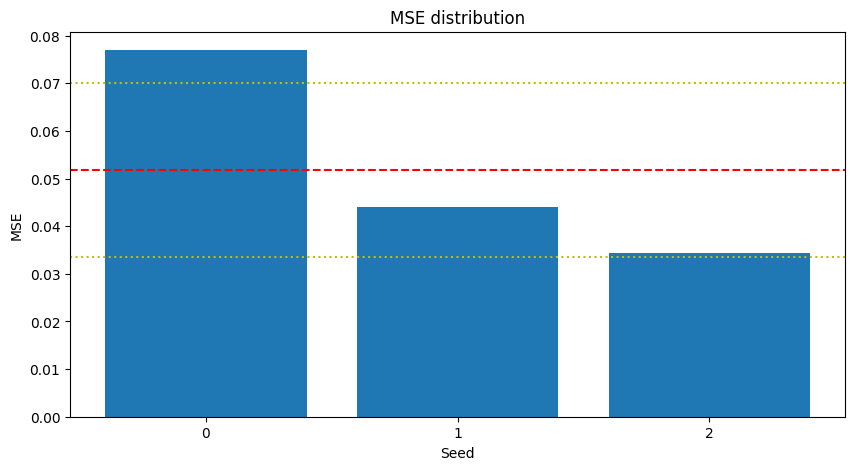

In [40]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 1. 100% unsupervised, 25% supervised

In [41]:
ratio_unsup = 0.25 # 20 % dei supervisionati
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 1851 (unsupervised), 15864 (test)


In [42]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [43]:
tru_st = cst.remove_rul(tru_s)

In [44]:
trsu_s = pd.concat((trs_s, tru_st))

In [45]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1078/1078 [==============================] - 15s 12ms/step - loss: 0.0038 - mse: 0.1650 - cst: 0.0038
Epoch 2/5
1078/1078 [==============================] - 12s 11ms/step - loss: 6.2572e-04 - mse: 0.1396 - cst: 6.2572e-04
Epoch 3/5
1078/1078 [==============================] - 11s 10ms/step - loss: 5.9876e-04 - mse: 0.1321 - cst: 5.9876e-04
Epoch 4/5
1078/1078 [==============================] - 12s 11ms/step - loss: 5.5904e-04 - mse: 0.1265 - cst: 5.5904e-04
Epoch 5/5
496/496 [==============================] - 1s 2ms/step
Epoch 1/5
1078/1078 [==============================] - 12s 10ms/step - loss: 0.0013 - mse: 0.1979 - cst: 0.0013
Epoch 2/5
1078/1078 [==============================] - 11s 10ms/step - loss: 5.5562e-04 - mse: 0.1531 - cst: 5.5562e-04
Epoch 3/5
1078/1078 [==============================] - 11s 10ms/step - loss: 5.4102e-04 - mse: 0.1237 - cst: 5.4102e-04
Epoch 4/5
1078/1078 [==============================] - 11s 10ms/step - loss: 5.3371e-04 - mse: 0.1052 - cst: 5.

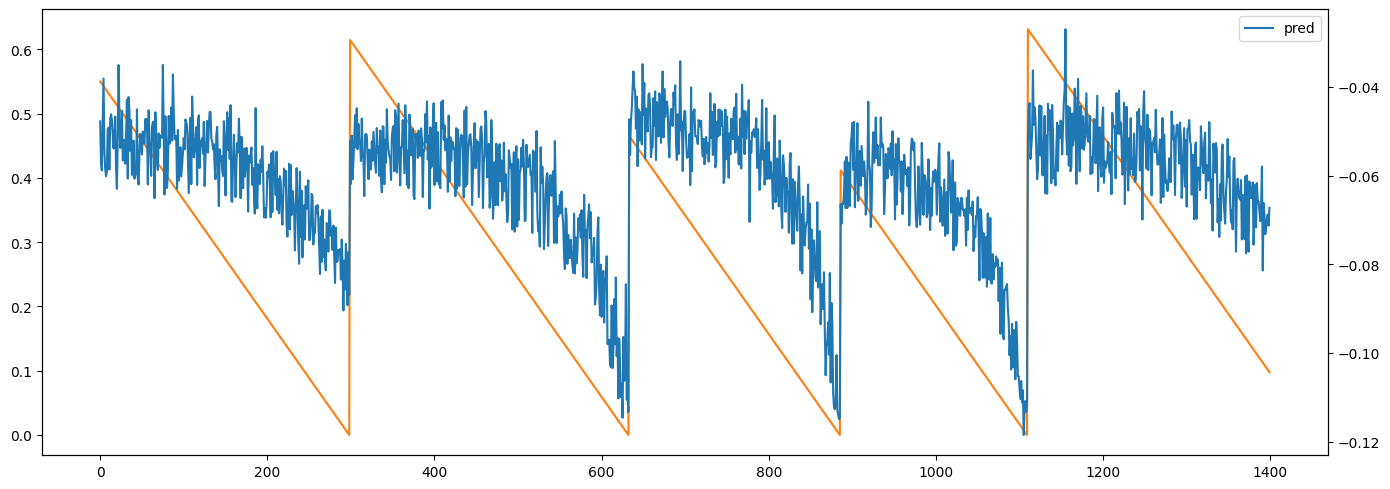

In [46]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [47]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0942
Deviazione standard della MSE: 0.0239


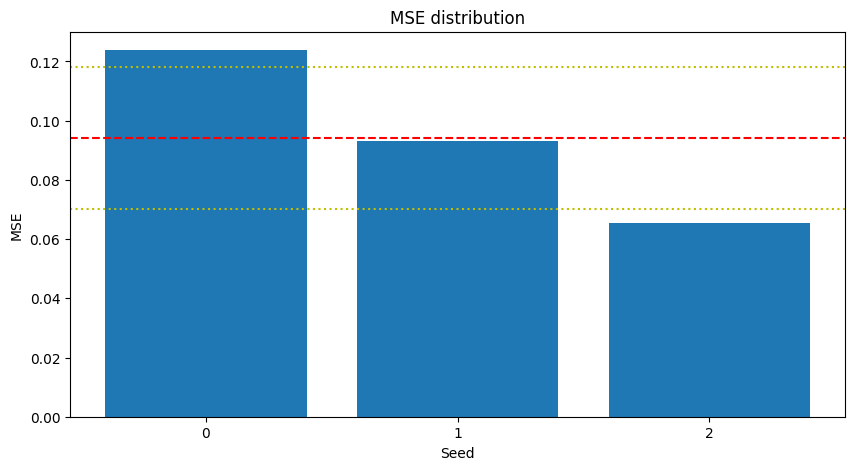

In [48]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

### Task 4: Knowledge injection by adding a new regularizer. We want to enforce the RUL being strictly positive

Prova del regularizer (da testare). Gamma per ora 1.0 ma da fare un po' di esperimenti / tuning
#TODO Ricordarsi di gestire input data

In [36]:
#usando unsupervised 100% e gamma = 0.1 -> Media della MSE: 0.0324, Deviazione standard della MSE: 0.0072

In [51]:
pred = []
for i in range(3):
    np.random.seed(i)
    model = cst.CstPosRULRegressor(len(dt_in), alpha=0.5, beta=0.2, gamma=1.0, maxrul=100, hidden=[64, 32])
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    model.compile(optimizer='Adam', run_eagerly=False)
    history = model.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(model.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0029 - mse: 0.0000e+00 - cst: 0.0129 - positivity_regularizer: 3.3505e-04
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0022 - mse: 0.0000e+00 - cst: 0.0110 - positivity_regularizer: 1.5379e-08
Epoch 3/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0022 - mse: 0.0000e+00 - cst: 0.0109 - positivity_regularizer: 3.6429e-07
Epoch 4/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0022 - mse: 0.0000e+00 - cst: 0.0109 - positivity_regularizer: 1.9340e-07
Epoch 5/5
496/496 [==============================] - 0s 398us/step
Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0025 - mse: 0.0000e+00 - cst: 0.0117 - positivity_regularizer: 1.3206e-04
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0022 - mse: 0.0000e+00 - cst: 0.0110 - positivity_regularizer: 8.8942e-08
Epoch 3/5
1339/1339 [======

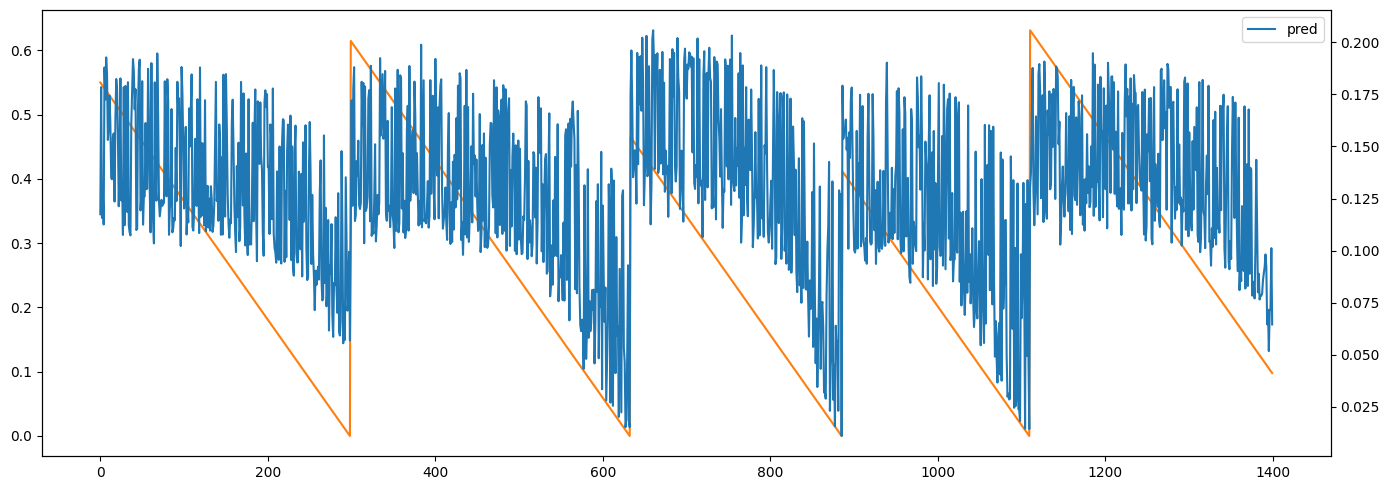

In [52]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [53]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0319
Deviazione standard della MSE: 0.0065


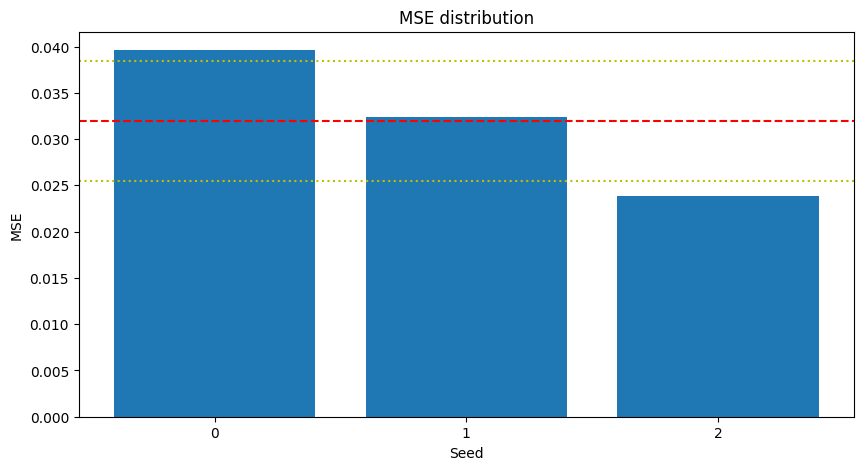

In [54]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

### Task 5: Lagrangian for dimanic weight of the loss function

In [28]:
didi_thr = 0.13
pred = []
for i in range(3):
    nn4 = cst.LagDualDIDIRegressor(tru_st[dt_in], thr=didi_thr, hidden=[])
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn4.compile(optimizer='Adam', loss='mse')
    history = nn4.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn4.predict(ts_s[dt_in]).ravel())

Epoch 1/5


KeyError: in user code:

    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/app/notebooks/util/cst.py", line 678, in train_step
        self.optimizer.apply_gradients(zip(grads, mul_vars))
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable alpha:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [ ]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)